In [90]:
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import yfinance as yf


In [91]:
tsla_data = yf.download('TSLA', start='2024-01-01', end='2024-12-30')
stock_data = yf.download('AAPL', start='2024-01-01', end='2024-12-30')


tsla_data.head(10)

/tmp/ipython-input-2741502016.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  tsla_data = yf.download('TSLA', start='2024-01-01', end='2024-12-30')
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-2741502016.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock_data = yf.download('AAPL', start='2024-01-01', end='2024-12-30')
[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,TSLA,TSLA,TSLA,TSLA,TSLA
Date,,,,,
2024-01-02,248.419998,251.250000,244.410004,250.080002,104654200
2024-01-03,238.449997,245.679993,236.320007,244.979996,121082600
2024-01-04,237.929993,242.699997,237.729996,239.250000,102629300
2024-01-05,237.490005,240.119995,234.899994,236.860001,92488900
2024-01-08,240.449997,241.250000,235.300003,236.139999,85166600
2024-01-09,234.960007,238.960007,232.039993,238.110001,96705700
2024-01-10,233.940002,235.500000,231.289993,235.100006,91628500
2024-01-11,227.220001,230.929993,225.369995,230.570007,105873600


In [92]:
stock_data.head(10)

Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2024-01-02,184.290421,187.070068,182.553143,185.789438,82488700
2024-01-03,182.910538,184.528693,182.096492,182.880757,58414500
2024-01-04,180.587524,181.758939,179.565014,180.825770,71983600
2024-01-05,179.862839,181.431354,178.860187,180.666963,62379700
2024-01-08,184.210999,184.250716,180.180517,180.766224,59144500
2024-01-09,183.794067,183.803989,181.401584,182.582935,42841800
2024-01-10,184.836426,185.044891,182.582924,183.009806,46792900
2024-01-11,184.240768,185.690161,182.285089,185.183859,49128400


### TSLA data plot

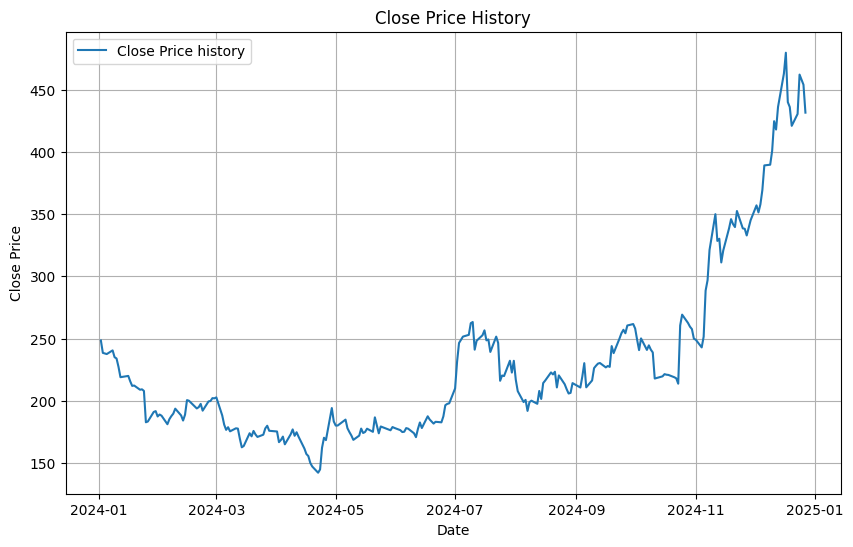

In [93]:
plt.figure(figsize=(10,6))
plt.plot(tsla_data.index, tsla_data['Close'], label='Close Price history')
plt.title('Close Price History')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.show()

### Apple Data plot

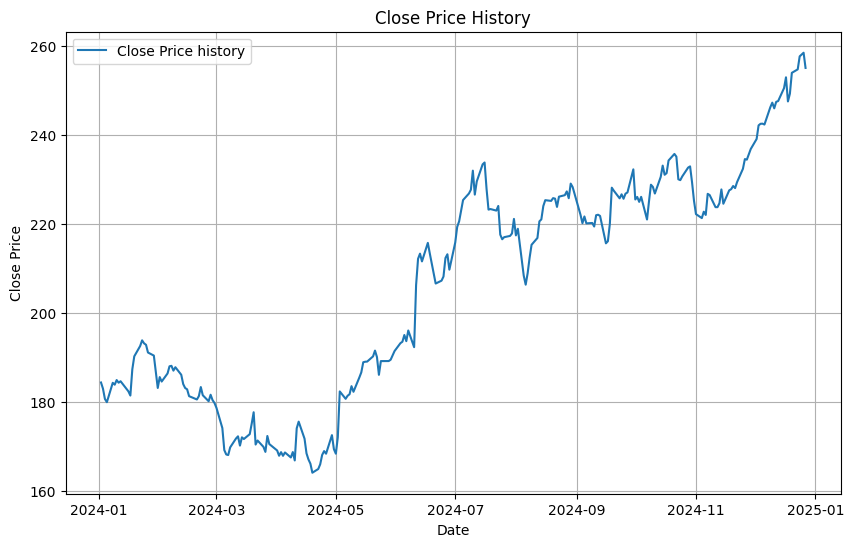

In [94]:
plt.figure(figsize=(10,6))
plt.plot(stock_data.index, stock_data['Close'], label='Close Price history')
plt.title('Close Price History')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.show()

### Multivariate Time Series...
---Vector Models

In [95]:
stock_data['TSLA_Close'] = tsla_data['Close']
stock_data['AAPL_Close'] = stock_data['Close'].shift()
stock_data.dropna(inplace=True)


from statsmodels.tsa.stattools import grangercausalitytests

## performing Granger-Causality test,,, used to check if one time series data effects another or causes the other
# Display head before dropping NaNs to inspect the data
granger_caulity_test = grangercausalitytests(stock_data[['AAPL_Close', 'TSLA_Close']].dropna(),  maxlag=[14])
print()


Granger Causality
number of lags (no zero) 14
ssr based F test:         F=1.9395  , p=0.0241  , df_denom=206, df_num=14
ssr based chi2 test:   chi2=30.9761 , p=0.0056  , df=14
likelihood ratio test: chi2=29.0980 , p=0.0101  , df=14
parameter F test:         F=1.9395  , p=0.0241  , df_denom=206, df_num=14



### "Apple's past stock prices give useful information to predict Tesla's future prices.


- but at the same point,,, it doesn't mean apple causes tsla...

### Now fitting the Vector Model

In [96]:
data = stock_data[['AAPL_Close', 'TSLA_Close']].diff().dropna()
train_data, test_data = data[:-14], data[-14:]

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


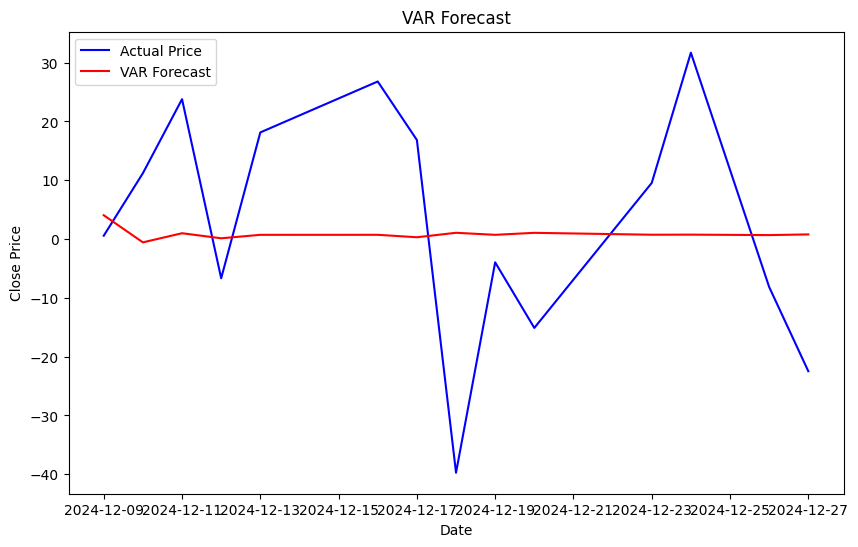

RMSE Score: 19.95


In [97]:
from statsmodels.tsa.api import VAR
from sklearn.metrics import mean_squared_error


## Vector AutoRegressive
model = VAR(train_data)
result = model.fit(maxlags=7)
predictions = result.forecast(train_data.values[-result.k_ar:], steps=len(test_data))

predictions = pd.DataFrame(predictions, index=test_data.index, columns=test_data.columns)

## plotting
plt.figure(figsize=(10,6))
plt.plot(test_data.index, test_data['TSLA_Close'], label='Actual Price', color='blue')
plt.plot(test_data.index, predictions['TSLA_Close'], label='VAR Forecast', color='red')
plt.legend()
plt.title('VAR Forecast')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.show()

### evaluating model using RMSE score...
rmse = round(np.sqrt(mean_squared_error(test_data['TSLA_Close'], predictions['TSLA_Close'])),2)
print(f"RMSE Score: {rmse}")

### RMSE is too high